In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import getcwd
from sklearn.svm import SVC



In [2]:
data_train=pd.read_csv("/content/drive/MyDrive/sign_mnist_train.csv")
data_test=pd.read_csv("/content/drive/MyDrive/sign_mnist_test.csv")

In [13]:
# In this section you will have to add another dimension to the data
#training_images = np.expand_dims(training_images, axis=3)
#testing_images = np.expand_dims(testing_images, axis=3)

# Extract features and labels
training_images = data_train.iloc[:, 1:].values
training_labels = data_train.iloc[:, 0].values
testing_images = data_test.iloc[:, 1:].values
testing_labels = data_test.iloc[:, 0].values


# Reshape images
training_images = training_images.reshape(-1, 28, 28)
testing_images = testing_images.reshape(-1, 28, 28)
training_images = np.expand_dims(training_images, axis=-1)
testing_images = np.expand_dims(testing_images, axis=-1)



print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

(27455, 28, 28, 1)
(27455,)
(7172, 28, 28, 1)
(7172,)


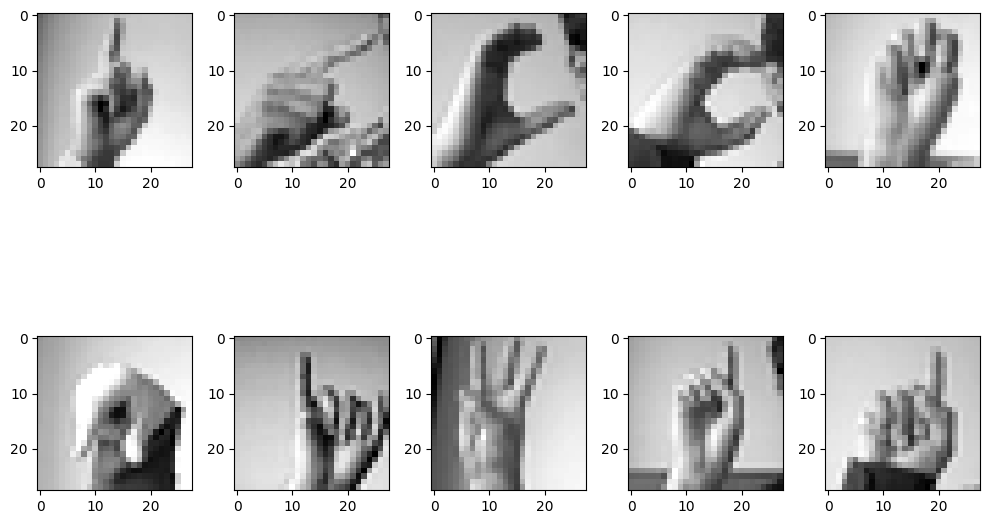

In [14]:
# Plotting the first 10 images
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,5)
fig.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(training_images[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()

In [15]:
# Create an ImageDataGenerator and do Image Augmentation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale=1 / 255
)

# Keep These
print(training_images.shape)
print(testing_images.shape)

# Their output should be:
# (27455, 28, 28, 1)
# (7172, 28, 28, 1)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
])
# Compile Model.
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# Train the Model
history = model.fit_generator(train_datagen.flow(training_images, training_labels, batch_size=32),
                              steps_per_epoch=len(training_images) / 32,
                              epochs=10,
                              validation_data=validation_datagen.flow(testing_images, testing_labels, batch_size=32),
                              validation_steps=len(testing_images) / 32)
# Extract features using the CNN model
cnn_model = tf.keras.models.Model(inputs=model.input, outputs=model.layers[-2].output)
training_features = cnn_model.predict(training_images[..., np.newaxis])
testing_features = cnn_model.predict(testing_images[..., np.newaxis])

# Flatten features
training_features_flat = training_features.reshape(training_features.shape[0], -1)
testing_features_flat = testing_features.reshape(testing_features.shape[0], -1)

# Create and train SVM model
svm_model = SVC(kernel='linear')  # You can use different kernels if needed
svm_model.fit(training_features_flat, training_labels)

# Evaluate the SVM model
svm_predictions = svm_model.predict(testing_features_flat)

Epoch 1/10


<ipython-input-16-928649bac0c5>:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(training_images, training_labels, batch_size=32),


857/857 [==============================] - 21s 24ms/step - loss: 2.6034 - accuracy: 0.2026 - val_loss: 1.6452 - val_accuracy: 0.4667
Epoch 2/10
857/857 [==============================] - 20s 23ms/step - loss: 1.8064 - accuracy: 0.4165 - val_loss: 1.0959 - val_accuracy: 0.6170
Epoch 3/10
857/857 [==============================] - 21s 24ms/step - loss: 1.4173 - accuracy: 0.5356 - val_loss: 0.8187 - val_accuracy: 0.7030
Epoch 4/10
857/857 [==============================] - 21s 24ms/step - loss: 1.1546 - accuracy: 0.6149 - val_loss: 0.6239 - val_accuracy: 0.7690
Epoch 5/10
857/857 [==============================] - 20s 24ms/step - loss: 0.9838 - accuracy: 0.6722 - val_loss: 0.6355 - val_accuracy: 0.7724
Epoch 6/10
857/857 [==============================] - 21s 24ms/step - loss: 0.8483 - accuracy: 0.7139 - val_loss: 0.4415 - val_accuracy: 0.8314
Epoch 7/10
857/857 [==============================] - 20s 23ms/step - loss: 0.7586 - accuracy: 0.7463 - val_loss: 0.4236 - val_accuracy: 0.8447
Epo

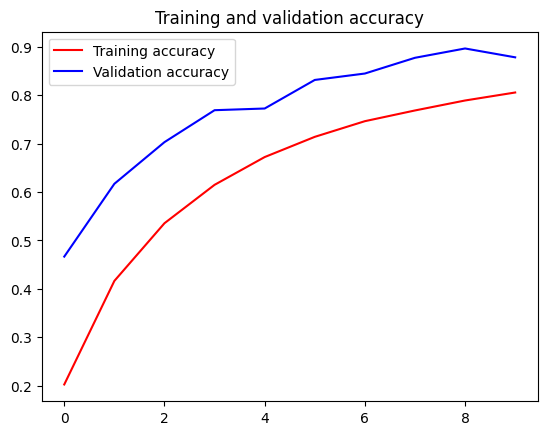

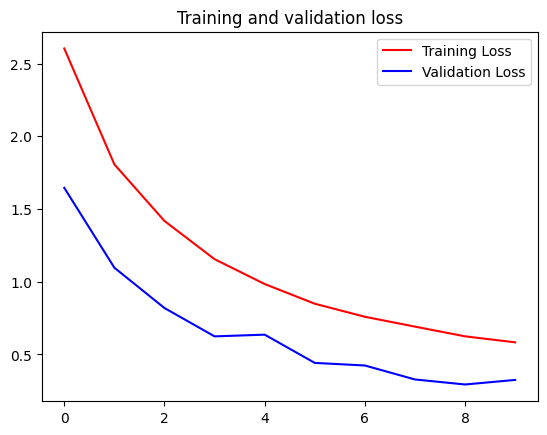

In [17]:
#accuracy and loss

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

225/225 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      0.94      0.97       432
           2       0.97      1.00      0.99       310
           3       1.00      1.00      1.00       245
           4       0.92      1.00      0.96       498
           5       1.00      1.00      1.00       247
           6       0.86      1.00      0.93       348
           7       1.00      0.93      0.96       436
           8       0.99      1.00      0.99       288
          10       0.98      1.00      0.99       331
          11       1.00      1.00      1.00       209
          12       1.00      0.89      0.94       394
          13       1.00      1.00      1.00       291
          14       1.00      0.97      0.98       246
          15       1.00      1.00      1.00       347
          16       1.00      1.00      1.00       164
          17       0.91   

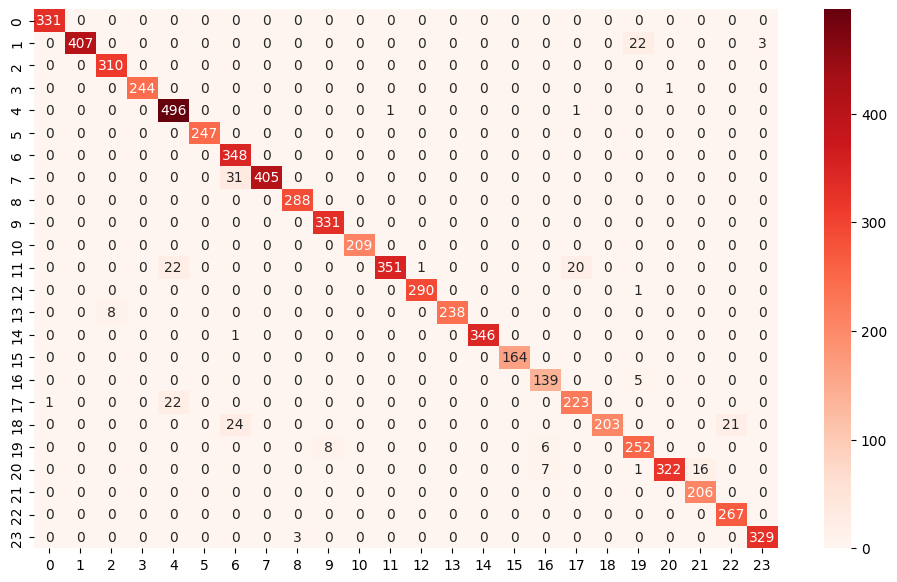

In [18]:
# Predictions
predictions = model.predict(testing_images)
predictions = np.argmax(predictions, axis=-1)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]

#Output
#array([ 6,  8, 11, 14, 18])

# Precision, recall, f1-score for all the classes
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

classes = ["Class " + str(i) for i in range(26) if i != 9]
# Print classification report
print(classification_report(testing_labels, svm_predictions))


# Plot confusion matrix
cm = confusion_matrix(testing_labels, svm_predictions)
plt.figure(figsize=(12, 7))
sns.heatmap(cm, cmap='Reds', annot=True, fmt='')
plt.show()